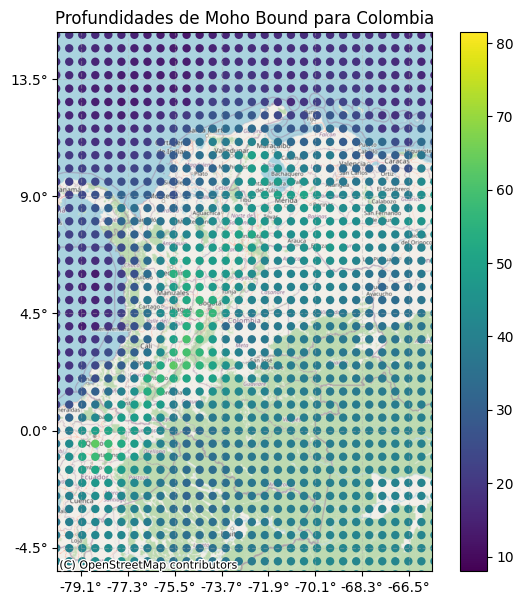

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
# Ruta al archivo shapefile (.shp)
ruta = r"C:\Git_SCA\AGE\Corteza"  # Usa r"" para evitar problemas con backslashes
# Cargar el shapefile
gdf = gpd.read_file(ruta)
# Reproyectar al sistema de Web Mercator (requerido por contextily)
gdf = gdf.to_crs(epsg=3857)
# Función para convertir de Web Mercator a grados decimales (aproximado)
def mercator_to_lon(x, _):
    return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _):
    return f"{y * 180 / 20037508.34:.1f}°"
# Crear el gráfico
fig, ax = plt.subplots(figsize=(7, 7))
# Graficar el shapefile con color según 'Z'
gdf.plot(
    column='Z',
    cmap='viridis',
    legend=True,
    ax=ax,
    linewidth=0.01,
    edgecolor='black'
)
# Centrar el mapa en Colombia (coordenadas en Web Mercator)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])
# Formatear los ejes con coordenadas bonitas
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
# Añadir líneas de grilla suaves
ax.grid(True, which='major', linestyle='--', alpha=0.4)
# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Título y visualización
plt.title("Profundidades de Moho Bound para Colombia")
#ax.set_axis_off()  # Si prefieres mostrar solo el mapa sin ejes, descomenta esta línea
plt.show()

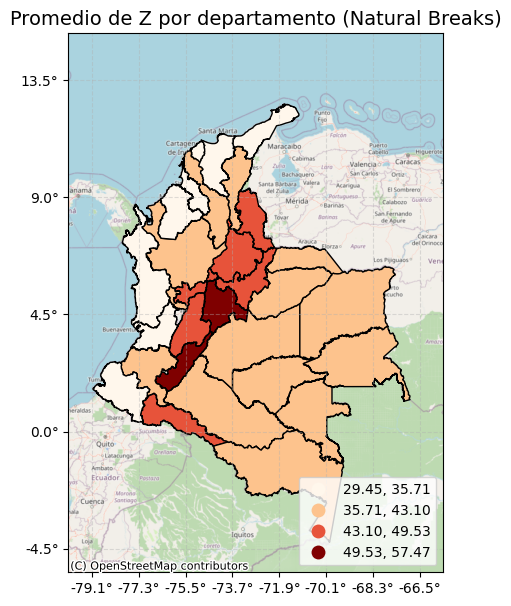

In [37]:

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# Ruta al shapefile con columna 'Z'
ruta_z = r"C:/Git_SCA\AGE/Corteza"
gdf = gpd.read_file(ruta_z)

# Ruta al shapefile de departamentos (polígonos)
ruta_dpto = r"C:/Git_SCA/AGE/departamentos"
departamentos = gpd.read_file(ruta_dpto)

# Asegurar mismo CRS
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
if departamentos.crs != gdf.crs:
    departamentos = departamentos.to_crs(gdf.crs)

# Spatial join: asociar puntos/zonas con 'Z' a departamentos
joined = gpd.sjoin(gdf, departamentos, predicate='within')

# Calcular promedio de Z por departamento (ajusta el nombre si no es 'NOMBRE_DPT')
promedios = joined.groupby('DeNombre')['Z'].mean().reset_index()
promedios.rename(columns={'Z': 'Z_promedio'}, inplace=True)

# Unir promedios al GeoDataFrame de departamentos
departamentos = departamentos.merge(promedios, on='DeNombre', how='left')

# Reproyectar para contexto de mapa base
departamentos = departamentos.to_crs(epsg=3857)

# Funciones para mostrar ejes en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"

# Crear figura y eje
fig, ax = plt.subplots(1, figsize=(7, 7))

# Mapa tipo choropleth
departamentos.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=4,
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower right'},
    ax=ax
)

# Limitar a Colombia (EPSG:3857)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])

# Ejes bonitos en grados
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base estándar de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

# Título del mapa
ax.set_title("Profundidades de Moho Bound por departamento (Natural Breaks)", fontsize=14)
plt.show()


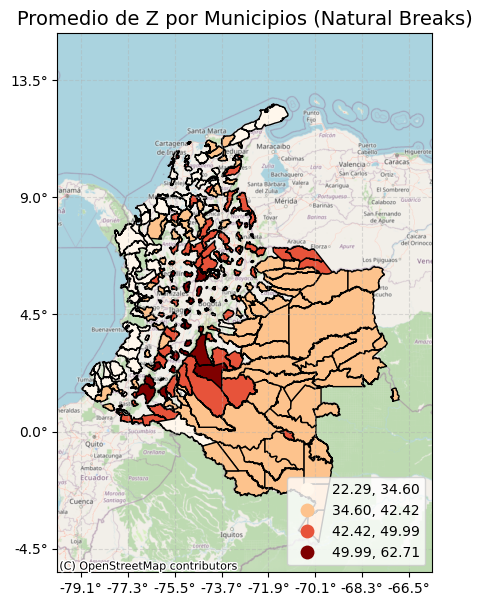

In [39]:

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# Ruta al shapefile con columna 'Z'
ruta_z = r"C:/Git_SCA\AGE/Corteza"
gdf = gpd.read_file(ruta_z)

# Ruta al shapefile de departamentos (polígonos)
ruta_dpto = r"C:/Git_SCA/AGE/municipios"
municipios = gpd.read_file(ruta_dpto)

# Asegurar mismo CRS
if gdf.crs is None:
    gdf.set_crs(epsg=4326, inplace=True)
if municipios.crs != gdf.crs:
    municipios = municipios.to_crs(gdf.crs)

# Spatial join: asociar puntos/zonas con 'Z' a departamentos
joined = gpd.sjoin(gdf, municipios, predicate='within')

# Calcular promedio de Z por departamento (ajusta el nombre si no es 'NOMBRE_DPT')
promedios = joined.groupby('MpNombre')['Z'].mean().reset_index()
promedios.rename(columns={'Z': 'Z_promedio'}, inplace=True)

# Unir promedios al GeoDataFrame de departamentos
municipios = municipios.merge(promedios, on='MpNombre', how='left')

# Reproyectar para contexto de mapa base
municipios = municipios.to_crs(epsg=3857)

# Funciones para mostrar ejes en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"

# Crear figura y eje
fig, ax = plt.subplots(1, figsize=(7, 7))

# Mapa tipo choropleth
municipios.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=4,
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower right'},
    ax=ax
)

# Limitar a Colombia (EPSG:3857)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])

# Ejes bonitos en grados
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base estándar de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

# Título del mapa
ax.set_title("Profundidades de Moho Bound por Municipios (Natural Breaks)", fontsize=14)
plt.show()


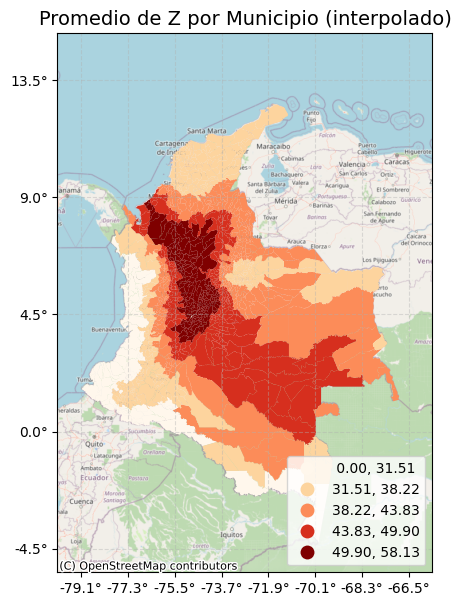

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
from rasterstats import zonal_stats
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import box
import rasterio
from rasterio.transform import from_origin

# Cargar puntos con Z
ruta_z = r"C:/Git_SCA/AGE/Corteza"
gdf = gpd.read_file(ruta_z)
gdf = gdf.to_crs(epsg=3857)

# Cargar municipios
ruta_mpios = r"C:/Git_SCA/AGE/municipios"
municipios = gpd.read_file(ruta_mpios)
municipios = municipios.to_crs(epsg=3857)

# Crear una grilla sobre Colombia
minx, miny, maxx, maxy = -8900000, -600000, -7300000, 1700000
res = 5000  # resolución de grilla en metros

x = np.arange(minx, maxx, res)
y = np.arange(miny, maxy, res)
xx, yy = np.meshgrid(x, y)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# IDW Interpolation
xy = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
tree = cKDTree(xy)
distances, indices = tree.query(grid_points, k=8)
weights = 1 / (distances + 1e-8)
z_vals = np.sum(weights * gdf['Z'].values[indices], axis=1) / np.sum(weights, axis=1)

# Crear raster interpolado
z_grid = z_vals.reshape(xx.shape)
transform = from_origin(minx, maxy, res, res)

# Guardar raster temporal
raster_path = "interpolacion_z.tif"
with rasterio.open(
    raster_path,
    'w',
    driver='GTiff',
    height=z_grid.shape[0],
    width=z_grid.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:3857',
    transform=transform,
) as dst:
    dst.write(z_grid.astype('float32'), 1)

# Calcular promedio de Z por municipio desde el raster interpolado
stats = zonal_stats(municipios, raster_path, stats="mean", geojson_out=True)
municipios_interp = gpd.GeoDataFrame.from_features(stats)
municipios_interp.rename(columns={"mean": "Z_promedio"}, inplace=True)

# Crear gráfico
fig, ax = plt.subplots(1, figsize=(7, 7))
municipios_interp.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=5,
    legend=True,
    legend_kwds={'loc': 'lower right'},
    ax=ax
)

# Limitar a Colombia
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Ejes en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

plt.title("Profundidades de Moho Bound por Municipio (interpolado)", fontsize=14)
plt.show()


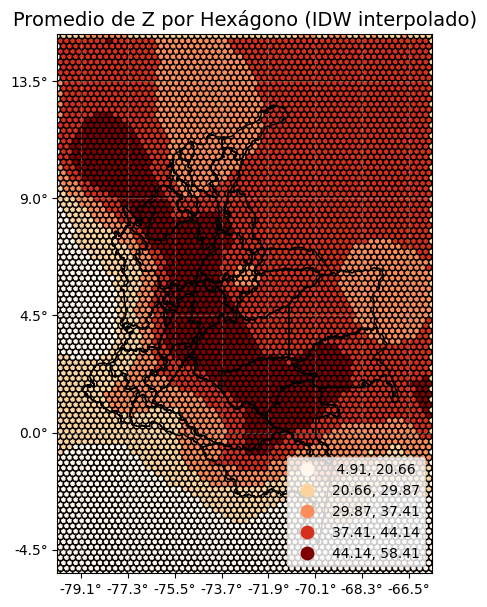

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
from rasterstats import zonal_stats
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import box, Polygon
import rasterio
from rasterio.transform import from_origin
import math

# === 1. Cargar puntos con columna Z ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Corteza").to_crs(epsg=3857)

departamentos = gpd.read_file(r"C:/Git_SCA/AGE/departamentos").to_crs(epsg=3857)


# === 2. Definir área de trabajo (Colombia continental) ===
minx, miny, maxx, maxy = -8900000, -600000, -7300000, 1700000
res = 5000  # resolución en metros
x = np.arange(minx, maxx, res)
y = np.arange(miny, maxy, res)
xx, yy = np.meshgrid(x, y)
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# === 3. Interpolación IDW ===
xy = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
tree = cKDTree(xy)
distances, indices = tree.query(grid_points, k=8)
weights = 1 / (distances + 1e-8)
z_vals = np.sum(weights * gdf['Z'].values[indices], axis=1) / np.sum(weights, axis=1)
z_grid = z_vals.reshape(xx.shape)

# === 4. Guardar raster interpolado temporalmente ===
transform = from_origin(minx, maxy, res, res)
raster_path = "interpolacion_idw_hex.tif"
with rasterio.open(
    raster_path, 'w', driver='GTiff',
    height=z_grid.shape[0], width=z_grid.shape[1],
    count=1, dtype='float32', crs='EPSG:3857',
    transform=transform
) as dst:
    dst.write(z_grid.astype('float32'), 1)

# === 5. Crear grilla hexagonal sobre Colombia ===
def create_hex_grid(bounds, hex_size):
    xmin, ymin, xmax, ymax = bounds
    dx = hex_size * 3**0.5
    dy = hex_size * 1.5
    cols = int((xmax - xmin) / dx) + 1
    rows = int((ymax - ymin) / dy) + 1
    hexagons = []
    for row in range(rows):
        for col in range(cols):
            x = xmin + col * dx
            if row % 2 == 1:
                x += dx / 2
            y = ymin + row * dy
            hex = Polygon([
                (x + hex_size * math.cos(math.radians(angle)), y + hex_size * math.sin(math.radians(angle)))
                for angle in range(0, 360, 60)
            ])
            if hex.intersects(box(minx, miny, maxx, maxy)):
                hexagons.append(hex)
    return gpd.GeoDataFrame(geometry=hexagons, crs="EPSG:3857")

hex_grid = create_hex_grid((minx, miny, maxx, maxy), hex_size=15000)

# === 6. Calcular promedio de Z por hexágono ===
stats = zonal_stats(hex_grid, raster_path, stats="mean", geojson_out=True)
hex_interp = gpd.GeoDataFrame.from_features(stats)
hex_interp.rename(columns={"mean": "Z_promedio"}, inplace=True)

# === 7. Visualizar el resultado ===
fig, ax = plt.subplots(figsize=(7, 7))
hex_interp.plot(
    column='Z_promedio',
    cmap='OrRd',
    scheme='natural_breaks',
    k=5,
    legend=True,
    legend_kwds={'loc': 'lower right'},
    ax=ax,
    edgecolor='black'
)

# Limitar a Colombia
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Coordenadas en grados
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base
departamentos.boundary.plot(ax=ax, edgecolor='black', linewidth=1, linestyle='-')
plt.title("Profundidades de Moho Bound Z por Hexágono (IDW interpolado)", fontsize=14)
plt.show()


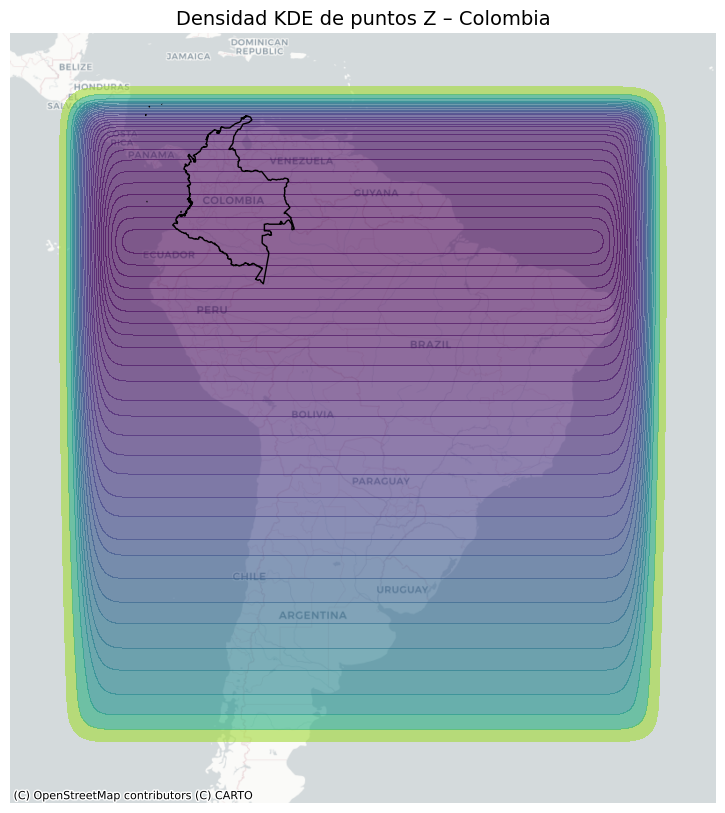

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import pandas as pd

# === 1. Cargar tus puntos ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Corteza").to_crs(epsg=3857)

# === 2. Convertir a DataFrame plano ===
df = pd.DataFrame({
    'x': gdf.geometry.x,
    'y': gdf.geometry.y
})

# === 3. Crear figura y KDE con Seaborn ===
fig, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(
    data=df,
    x='x', y='y',
    fill=True,
    cmap='viridis_r',
    alpha=0.6,
    bw_adjust=0.5,
    levels=30,
    ax=ax
)

# === 4. Añadir mapa base ===
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:3857')

# === 5. Opcional: superponer contorno de Colombia ===
colombia = gpd.read_file(r"C:/Git_SCA/AGE/colombia", layer='co').to_crs(epsg=3857)
colombia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# === 6. Limpiar ejes ===
ax.set_axis_off()
plt.title("Densidad KDE de puntos Z – Colombia", fontsize=14)
plt.show()
